# Análise dos testes

### Carregamento dos testes

In [12]:
from json import load

llama_quantized_test = load(open('../analysis/Llama-3.2-11B-Vision-Instruct_test_1000_class_only_quantized.json'))
llama_test = load(open('../analysis/Llama-3.2-11B-Vision-Instruct_test_1000_class_only.json'))
llama_derm_qlora_500 = load(open('../analysis/LLaMA_DERM_QLoRA_500_11B_test_1000_class_only.json'))
llama_derm_qlora_1000 = load(open('../analysis/LLaMA_DERM_QLoRA_1000_11B_test_1000_class_only.json'))
llama_derm_qlora_2000 = load(open('../analysis/LLaMA_DERM_QLoRA_2000_11B_test_1000_class_only.json'))
llama_derm_qlora_5000 = load(open('../analysis/LLaMA_DERM_QLoRA_5000_11B_test_1000_class_only.json'))
llama_derm_lora_500 = load(open('../analysis/LLaMA_DERM_LoRA_500_11B_test_1000_class_only.json'))
llama_derm_lora_1000 = load(open('../analysis/LLaMA_DERM_LoRA_1000_11B_test_1000_class_only.json'))
llama_derm_lora_5000 = load(open('../analysis/LLaMA_DERM_LoRA_5000_11B_test_1000_class_only.json'))

### Contagem das classes

In [13]:
from IPython.display import display, HTML
import pandas as pd
from collections import Counter


def create_distribution_table(counter: Counter, total: int, title: str) -> pd.DataFrame:
    """Create a formatted DataFrame from counter data"""
    df = pd.DataFrame([
        {
            'Answer': answer if len(answer) < 50 else answer[:51] + '...',
            'Count': count,
            'Percentage': count/total * 100
        }
        for answer, count in counter.items()
    ])

    df = df.sort_values('Count', ascending=False)
    df['Percentage'] = df['Percentage'].map('{:.1f}%'.format)

    # Style the table
    styled_df = df.style.set_caption(title).set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '120%')]},
        {'selector': 'th', 'props': [('text-align', 'left'), ('background-color', '#f0f0f0')]},
        {'selector': 'table', 'props': [('width', '100%')]},
    ]).hide(axis='index')

    return styled_df


def display_model_results(test_data, model_name):
    """Display expected vs actual results for a model"""
    results = test_data['results']
    expected_counter = Counter(item['expected'] for item in results)
    actual_counter = Counter(item['actual'] for item in results)

    total = len(results)

    display(HTML(f'<h2>{model_name}</h2>'))
    display(HTML("""
    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
        <div>
            """ + create_distribution_table(expected_counter, total, 'Expected Classes Distribution').to_html() + """
        </div>
        <div>
            """ + create_distribution_table(actual_counter, total, 'Model Predictions Distribution').to_html() + """
        </div>
    </div>
    <br><hr><br>
    """))


tests = [
    (llama_quantized_test, 'LLaMA Base Model (Quantized)'),
    (llama_test, 'LLaMA Base Model'),
    (llama_derm_qlora_500, 'LLaMA + QLoRA (500 samples)'),
    (llama_derm_qlora_1000, 'LLaMA + QLoRA (1000 samples)'),
    (llama_derm_qlora_2000, 'LLaMA + QLoRA (2000 samples)'),
    (llama_derm_qlora_5000, 'LLaMA + QLoRA (5000 samples)'),
    (llama_derm_lora_500, 'LLaMA + LoRA (500 samples)'),
    (llama_derm_lora_1000, 'LLaMA + LoRA (1000 samples)'),
    (llama_derm_lora_5000, 'LLaMA + LoRA (5000 samples)'),
]

for results, model_name in tests:
    display_model_results(results, model_name)

Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanoma.,976,97.6%
Melanocytic Nevi.,13,1.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanoma.,883,88.3%
Dermatofibroma.,64,6.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,737,73.7%
The skin lesion in the image is melanoma.,149,14.9%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanocytic Nevi.,582,58.2%
Melanoma.,213,21.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi.,677,67.7%
melanoma.,151,15.1%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,699,69.9%
The skin lesion in the image is melanoma.,113,11.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanocytic Nevi.,598,59.8%
Melanoma.,384,38.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanoma.,567,56.7%
Melanocytic Nevi.,408,40.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,716,71.6%
The skin lesion in the image is melanoma.,117,11.7%


### Processamento dos testes

In [14]:
from collections import Counter
import re

DISEASE_CLASSES = [
    'melanocytic Nevi',
    'melanoma',
    'benign keratosis-like lesions',
    'basal cell carcinoma',
    'actinic keratoses',
    'vascular lesions',
    'dermatofibroma'
]


def normalize_disease(text: str) -> str:
    """Normalize disease name to standard format"""
    text = text.lower().strip().strip('.')

    # Common variations mapping
    variations = {
        'melanocytic nevi': 'melanocytic Nevi',
        'nevus': 'melanocytic Nevi',
        'nevi': 'melanocytic Nevi',
        'melanoma': 'melanoma',
        'benign keratosis': 'benign keratosis-like lesions',
        'seborrheic keratosis': 'benign keratosis-like lesions',
        'basal cell': 'basal cell carcinoma',
        'actinic keratosis': 'actinic keratoses',
        'vascular': 'vascular lesions'
    }

    for variant, standard in variations.items():
        if variant in text:
            return standard

    return text


def classify_answer(text: str) -> str:
    """Classify model answer into standard disease class or unclear"""
    text = text.lower()

    # Count mentioned diseases
    mentioned_diseases = []
    for disease in DISEASE_CLASSES:
        if disease.lower() in text:
            mentioned_diseases.append(disease)

    # Handle classification
    if len(mentioned_diseases) == 0:
        return 'unclear answer'
    elif len(mentioned_diseases) > 1:
        return 'unclear answer (multiple)'
    else:
        return mentioned_diseases[0]


def process_and_display_results(test_data: dict, model_name: str) -> list[tuple[str, str]]:
    """Process and display results with standardized classifications. Returns list of (expected, classified) pairs"""
    results = test_data['results']
    total = len(results)

    # Process answers and create pairs
    processed_results = [
        {
            'expected': result['expected'],
            'actual': result['actual'],
            'classified': classify_answer(result['actual'])
        }
        for result in results
    ]

    # Create pairs list
    pairs = [(r['expected'], r['classified']) for r in processed_results]

    expected_counter = Counter(item['expected'] for item in processed_results)
    classified_counter = Counter(item['classified'] for item in processed_results)

    # Display results
    display(HTML(f'<h2>{model_name}</h2>'))
    display(HTML("""
    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
        <div>
            """ + create_distribution_table(expected_counter, total, 'Expected Classes').to_html() + """
        </div>
        <div>
            """ + create_distribution_table(classified_counter, total, 'Classified Predictions').to_html() + """
        </div>
    </div>
    <br><hr><br>
    """))

    return pairs


all_results = {}
for test_data, model_name in tests:
    all_results[model_name] = process_and_display_results(test_data, model_name)

Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanoma,976,97.6%
melanocytic Nevi,13,1.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanoma,883,88.3%
dermatofibroma,64,6.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,812,81.2%
melanoma,171,17.1%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,602,60.2%
melanoma,238,23.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,689,68.9%
melanoma,151,15.1%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,699,69.9%
melanoma,113,11.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,598,59.8%
melanoma,384,38.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanoma,567,56.7%
melanocytic Nevi,408,40.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,716,71.6%
melanoma,117,11.7%


### Análise

Model Accuracies:


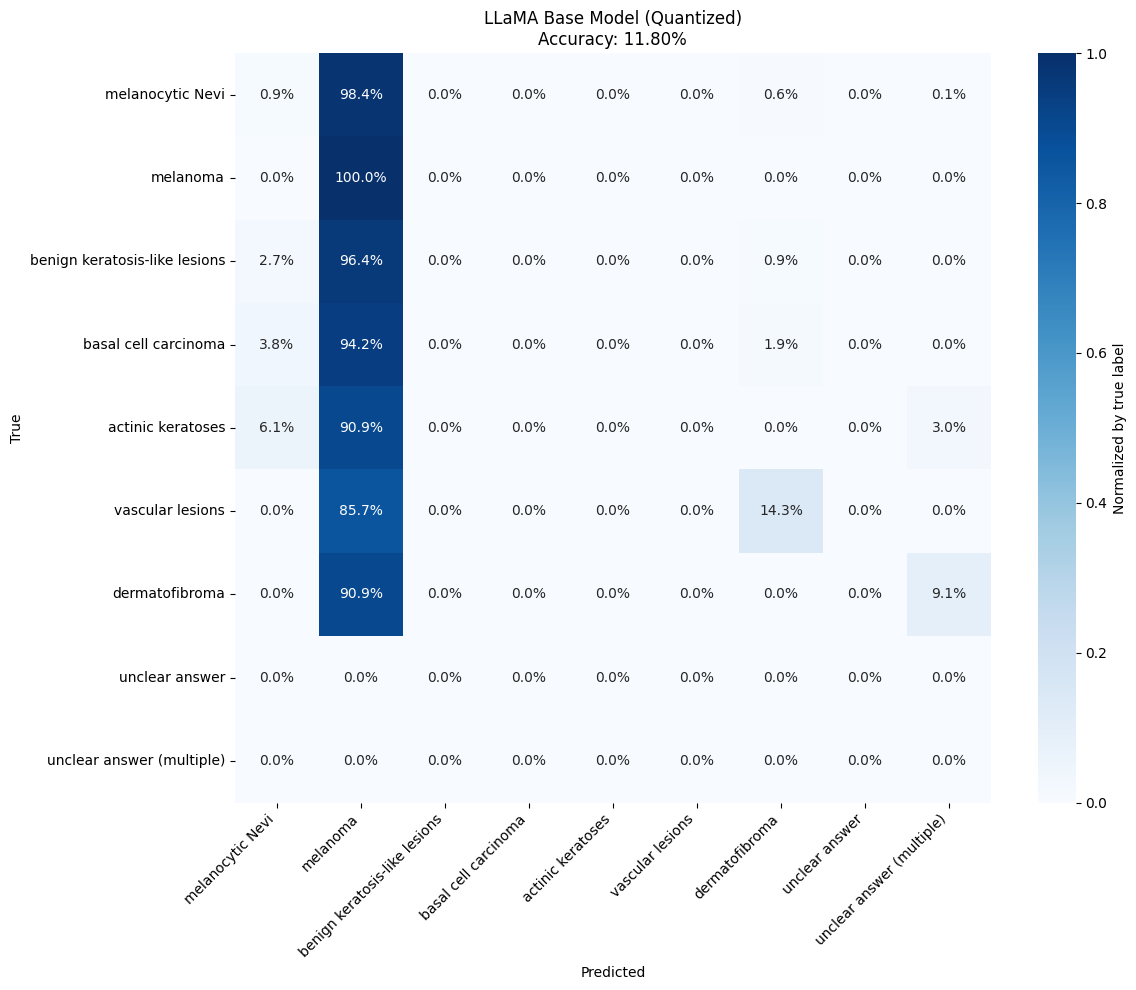

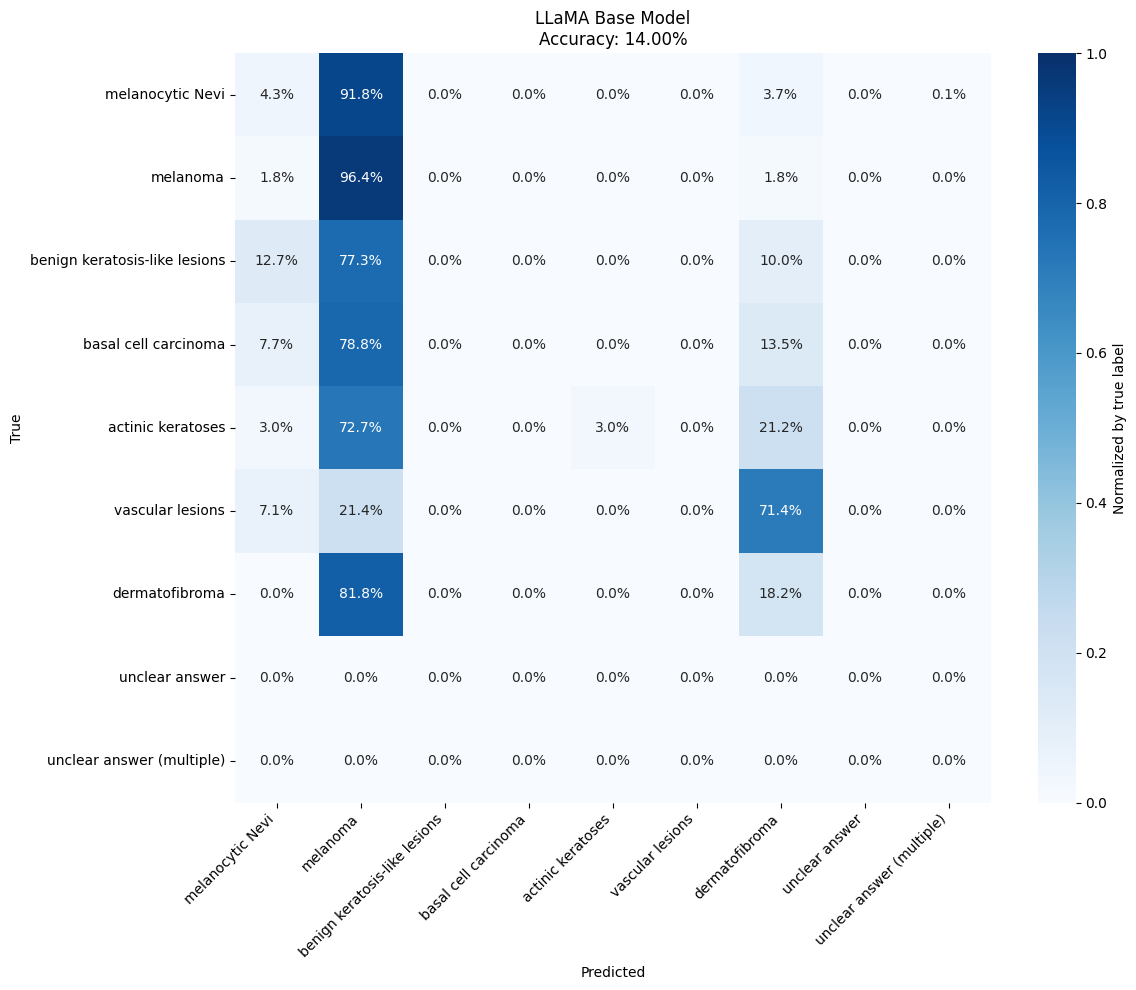

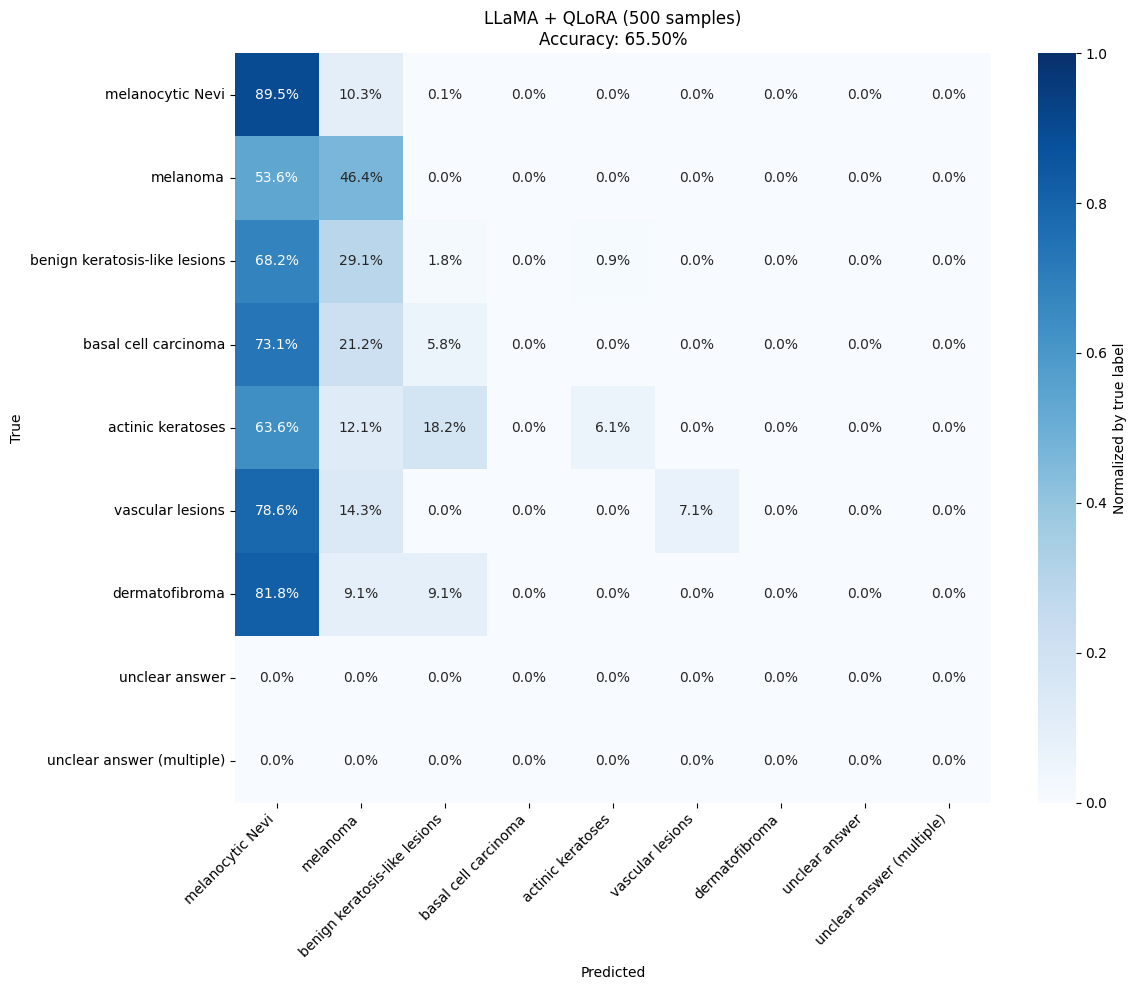

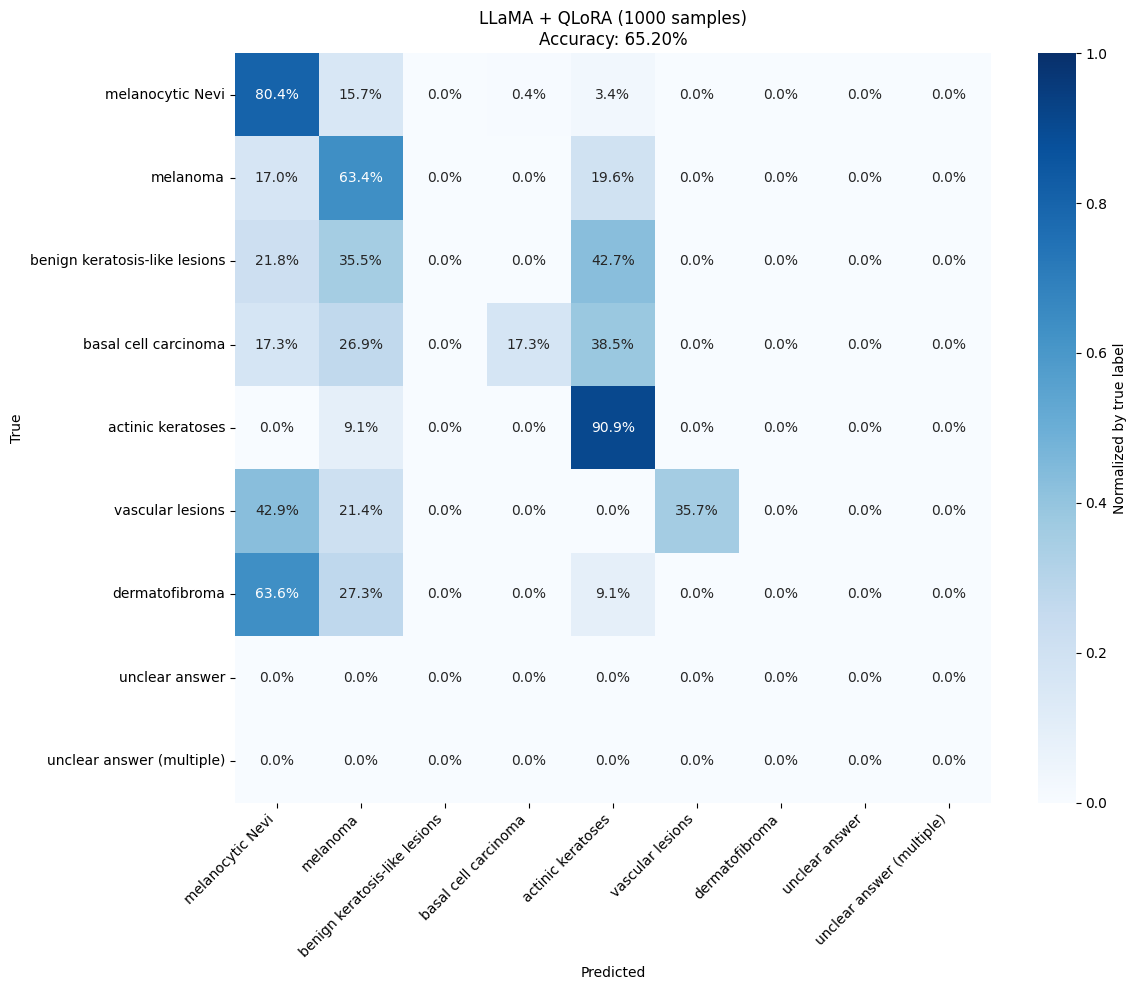

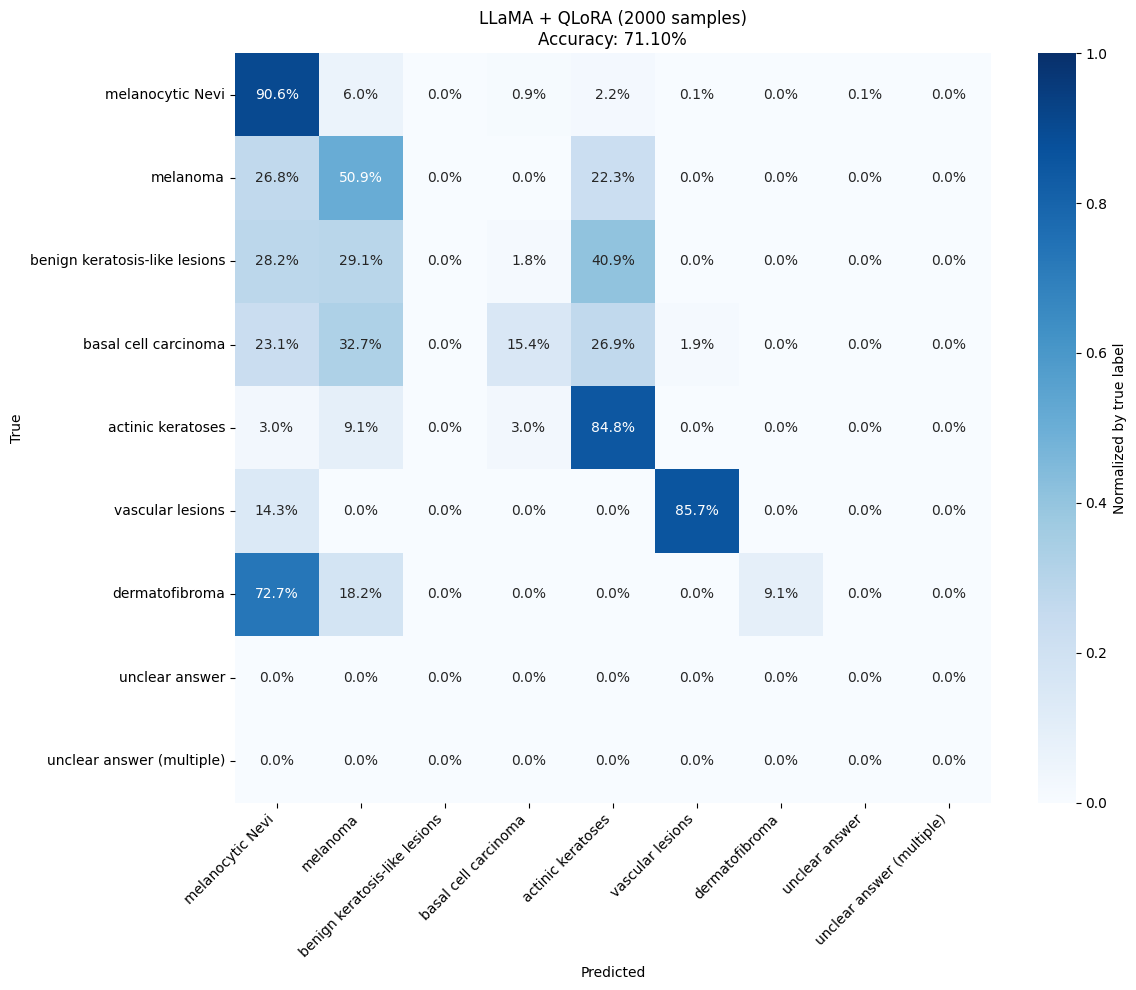

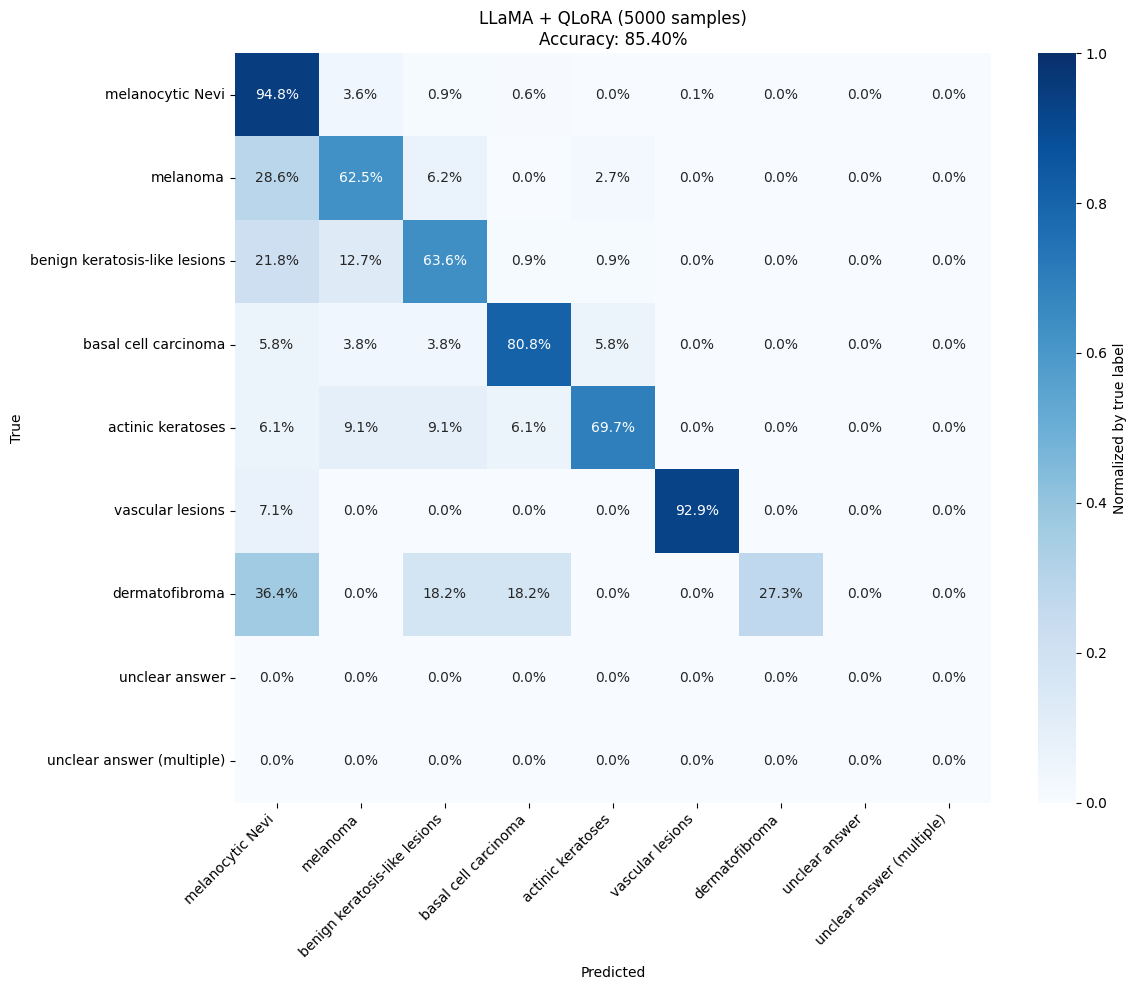

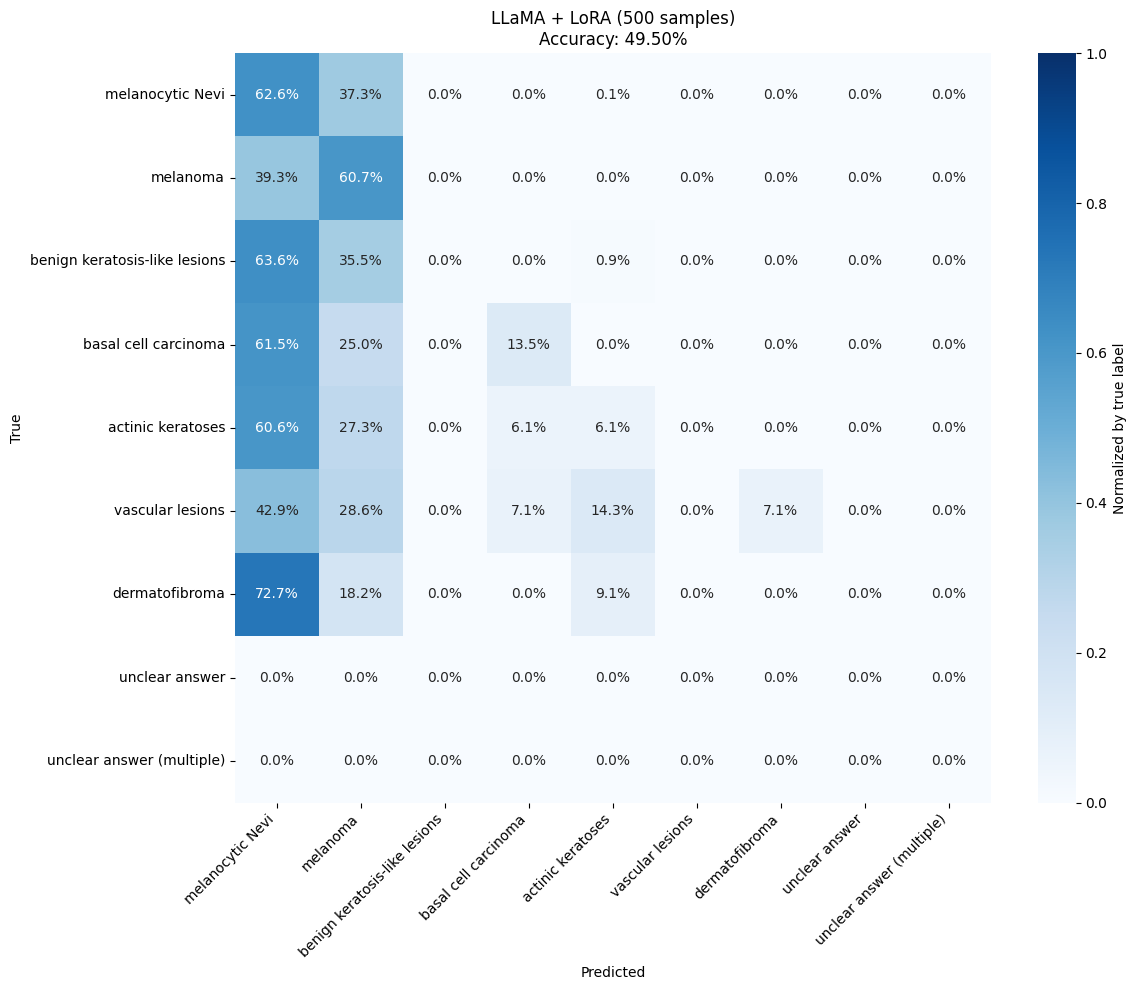

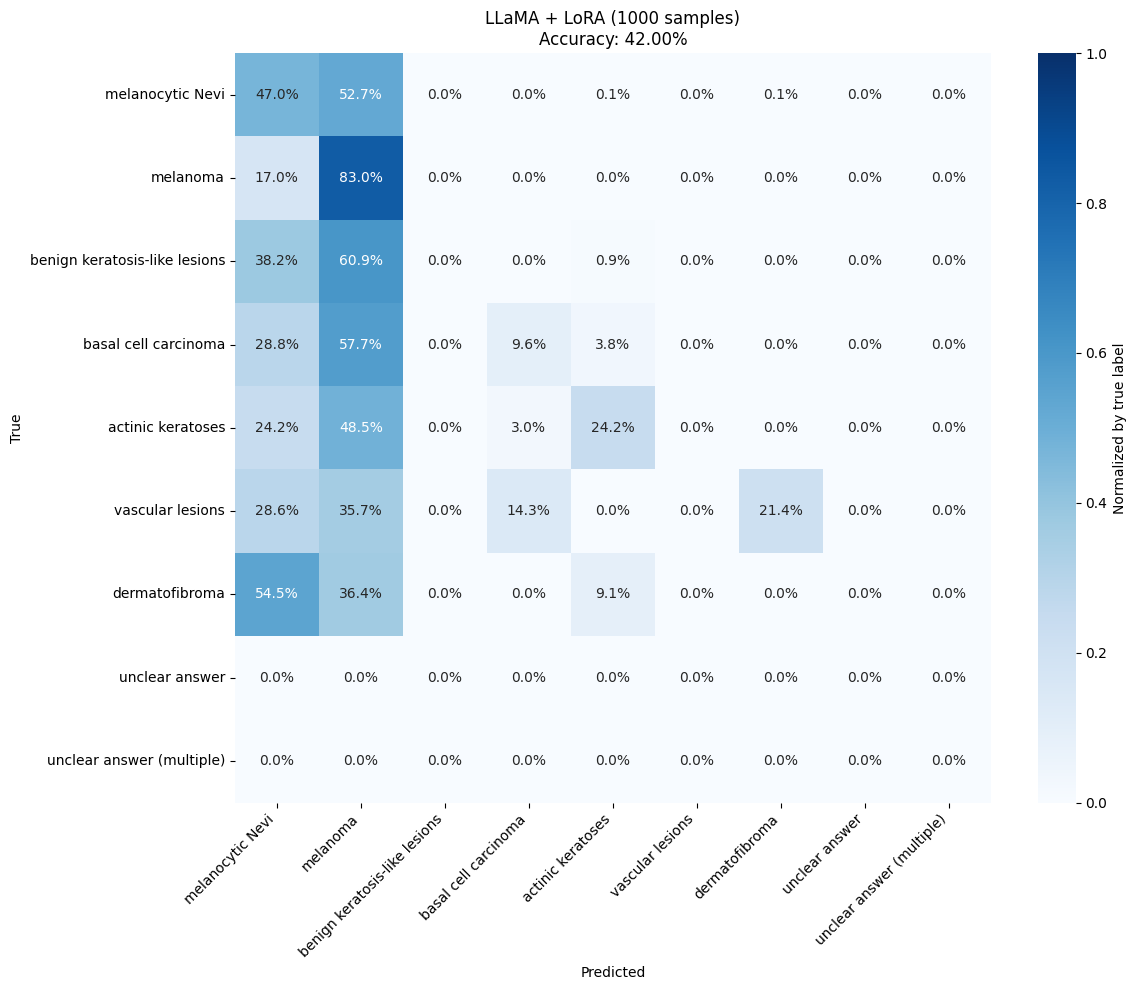

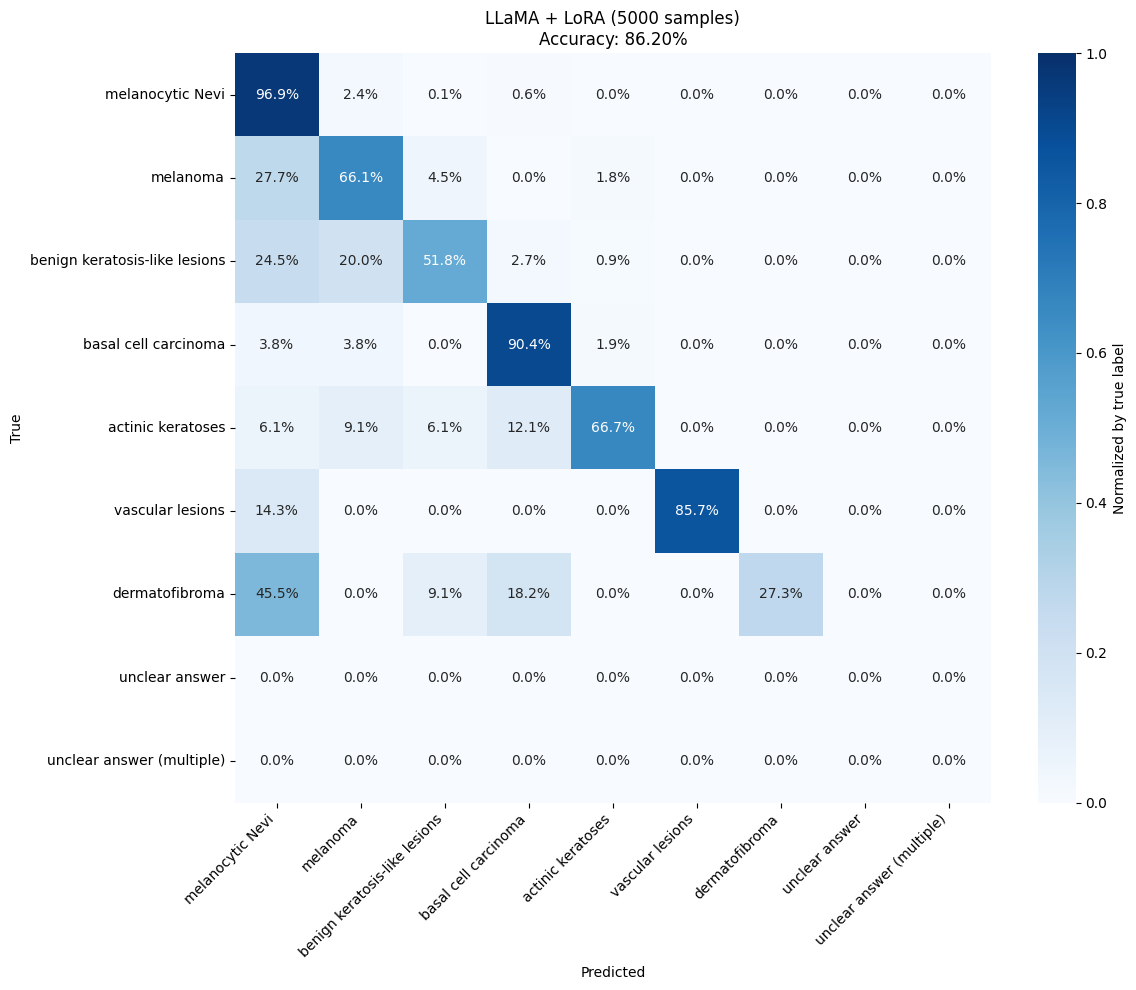

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix


def analyze_model_performance(pairs: list[tuple[str, str]], model_name: str):
    """Calculate accuracy and create normalized confusion matrix visualization"""
    y_true = [p[0] for p in pairs]
    y_pred = [p[1] for p in pairs]

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Create confusion matrix
    labels = DISEASE_CLASSES + ['unclear answer', 'unclear answer (multiple)']
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Safe normalization with handling for zero division
    row_sums = cm.sum(axis=1)
    cm_normalized = np.zeros_like(cm, dtype=float)
    for i in range(len(row_sums)):
        if row_sums[i] > 0:  # Only normalize non-empty classes
            cm_normalized[i] = cm[i] / row_sums[i]

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized,
                annot=True,
                fmt='.1%',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'Normalized by true label'})
    plt.title(f'{model_name}\nAccuracy: {accuracy:.2%}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy


print("Model Accuracies:")
accuracies = {}
for model_name, pairs in all_results.items():
    accuracies[model_name] = analyze_model_performance(pairs, model_name)